In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# 1. Problem Statement

In [2]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
print(train_df.head())
print("Number of training examples: ", len(train_df))

test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
print(test_df.head())
print("Number of training examples: ", len(test_df))


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
Number of training examples:  7613
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in Chi

The task in this assignment is to classify tweets as either 'disaster reports' or 'non-disaster reports' based on their textual contents. This can be useful, for example, to police, emergency first responders, and disaster-relief organizations to be able to quickly respond to such incidents.

We are also given "keyword" and "location" data, which tell us keywords used in a tweet and the location the tweet was sent from, if it is available (which appears to be not always).

The primary challenge arises from figurative, exagerative, or otherwise non-literal usage of words related to disasters;
e.g. saying that the sky is "ablaze" to describe the colors of a sunset could trigger false-positives.

# 2. EDA

In [10]:
len(train_df['keyword'].value_counts())

221

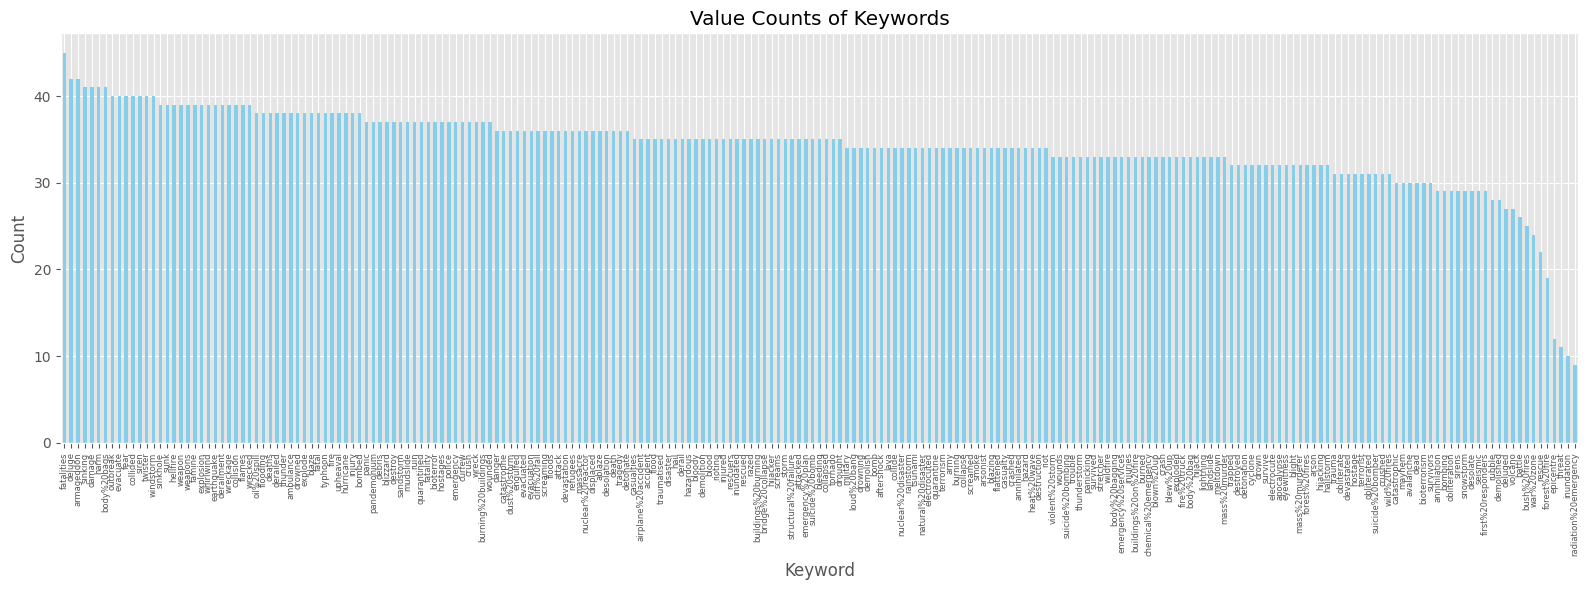

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

keyword_counts = train_df['keyword'].value_counts()

keyword_counts.plot(kind='bar', color='skyblue', figsize=(16, 6))
plt.title('Value Counts of Keywords')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='center', fontsize=6)
plt.tight_layout()
plt.show()


## 2.1 Data Cleaning

Number of missing keywords:  61
Number of missing locations:  2533


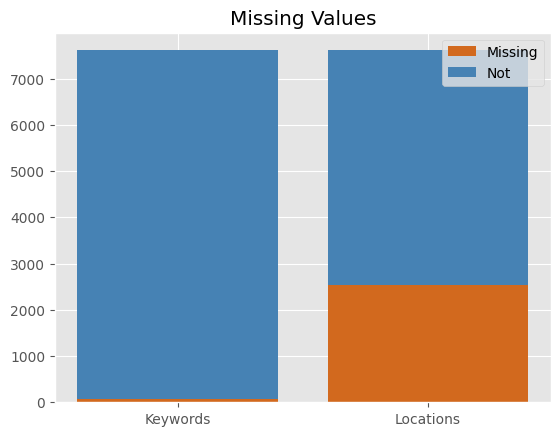

In [12]:
print("Number of missing keywords: ", len(train_df[train_df['keyword'].isna()]))
print("Number of missing locations: ", len(train_df[train_df['location'].isna()]))

non_missing_keywords = len(train_df) - len(train_df[train_df['keyword'].isna()])
non_missing_locations = len(train_df) - len(train_df[train_df['location'].isna()])

plt.style.use('ggplot')
missing_keywords = len(train_df[train_df['keyword'].isna()])
missing_locations = len(train_df[train_df['location'].isna()])
fig, ax = plt.subplots()

ax.bar(['Keywords', 'Locations'], [missing_keywords, missing_locations], color='chocolate', label='Missing')
ax.bar(['Keywords', 'Locations'], [non_missing_keywords, non_missing_locations], color='steelblue', label='Not', bottom=[missing_keywords, missing_locations])

ax.set_title('Missing Values')
ax.legend()
plt.show()

We can see that the number of missing location values is relatively high, about a third of the training set. Relatively fewer keywords are missing; but what exactly are the keywords?

In [13]:
# Print out the first 20 non-na keywords
print(train_df[~train_df['keyword'].isna()]['keyword'].unique()[:20])

['ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing']


For the purposes of this assignment I choose to drop both of these features and focus on the textual contents of the tweets as:
1. Many of the location values are missing.
2. Even if they weren't, does it make sense that a location would be significantly correlated with figurative language usage?
3. Keywords don't give us any information about whether or not the keyword is used figuratively.



# 3. Modeling

For the purposes of this task, I choose to evaluate two different architectures:
1. Fine-tuned BERT-large
2. Fully trained RNN

## 3.1 BERT-based approach
### 3.1.1 Architecture
I begin with the BERT-large model (introduced in Devlin et al., 2018), a large language model of the transformer architecture that is particularly suited to classification problems. Unlike RNNs, transformers are feed forward neural networks (i.e. there is no recurrence).

Neural network-based models like transformers make use of a "tokenizer", which maps words (or fragments of words) to unique integers which act as features and are what we feed to the model as inputs.

In [14]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-large-cased')

print("Hello world! tokenized: ", tokenizer.encode("Hello world!"))

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

Hello world! tokenized:  [101, 8667, 1362, 106, 102]


In [15]:
model = BertForSequenceClassification.from_pretrained('bert-large-cased', num_labels=len(train_df['target'].unique()), device_map='cuda')

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Here I create a dataloader and split the training data into an 80/20 validation split as we aren't provided with validation data:

In [16]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split


train_data, val_data, train_labels, val_labels = train_test_split(
    train_df["text"], 
    train_df["target"], 
    test_size=0.2, 
    random_state=42
)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

class CustomDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len, labels=None):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        
        out = {'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()}

        out['labels'] = torch.tensor(label, dtype=torch.long)
                
        return out
    
train_dataset = CustomDataset(train_data, tokenizer, 128, labels=train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = CustomDataset(val_data, tokenizer, 128, labels=val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False) 

### 3.1.2 BERT Training

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(p):
    predictions = p.predictions.argmax(axis=1)
    label_ids = p.label_ids
    accuracy = (predictions == label_ids).mean()
    precision = precision_score(label_ids, predictions, average='weighted')
    recall = recall_score(label_ids, predictions, average='weighted')
    f1 = f1_score(label_ids, predictions, average='weighted')
    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [18]:
# Early stopping, when validation loss stops decreasing for 5 epochs in a row stop training.
from transformers import EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(early_stopping_patience=5)

In [20]:
from transformers import Trainer, TrainingArguments
from transformers import AdamW, get_linear_schedule_with_warmup


optimizer = AdamW(model.parameters(), lr=1e-6)

training_args = TrainingArguments(
    output_dir="./bert_model",
    num_train_epochs=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-6,
    load_best_model_at_end=True, 
    save_total_limit=1,  
)

total_steps = training_args.num_train_epochs * len(train_dataset) // training_args.per_device_train_batch_size

# Learning rate warmup over the first 10 epochs to avoid early overfitting
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics,
)


trainer.add_callback(early_stopping)
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.700800,0.683473,0.556796,0.516464,0.556796,0.486783
2,0.681900,0.654959,0.664478,0.719342,0.664478,0.612417
3,0.640400,0.540696,0.783979,0.783114,0.783979,0.782495
4,0.501600,0.441066,0.818779,0.820455,0.818779,0.816328
5,0.446400,0.417094,0.829941,0.830215,0.829941,0.828507
6,0.398800,0.425187,0.828628,0.828395,0.828628,0.827552
7,0.378800,0.444225,0.833224,0.832951,0.833224,0.833051
8,0.362100,0.462810,0.829284,0.828816,0.829284,0.828874
9,0.336800,0.481396,0.829284,0.828948,0.829284,0.828337
10,0.321000,0.536135,0.827315,0.826934,0.827315,0.826381


TrainOutput(global_step=7620, training_loss=0.4747615003210353, metrics={'train_runtime': 3207.0738, 'train_samples_per_second': 189.893, 'train_steps_per_second': 23.76, 'total_flos': 1.41886550066688e+16, 'train_loss': 0.4747615003210353, 'epoch': 10.0})

## 3.2 RNN Approach
### 3.2.1 Architecture
For the RNN-based approach I follow the best performing architecture from (Nistor et al., 2021), which consists of:

* 2 layers of 64 units each
* GRU memory cells
* One-hot Vectors as the mechanism for embedding the sentences

In order for one-hot vectors (i.e. a boolean column for each unique term) to be an effective method for embeddings, an additional data processing step is necessary in which stop words (common words such as "the", "and", etc.) are removed and all text is converted to lowercase.

### 3.2.2 Data processing for RNN

In [74]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Preprocessing function that:
# - converts to lower case
# - removes punctuation
# - tokenizes (splits words on spaces)
# - removes stopwords
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

train_df['processed_text'] = train_df['text'].apply(preprocess_text)

vectorizer = CountVectorizer(binary=True)

vectorizer.fit(train_df['processed_text'])

one_hot_embeddings = vectorizer.transform(train_df['processed_text']).toarray()

#one_hot_df = pd.DataFrame(one_hot_embeddings, columns=vectorizer.get_feature_names_out())

#result_df = pd.concat([train_df, one_hot_df], axis=1)

train_df['embedding'] = [one_hot_embeddings[i, :] for i in range(one_hot_embeddings.shape[0])]

In [75]:
train_df.head()

,id,keyword,location,text,target,processed_text,embedding
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### 3.2.3 RNN Training

In [141]:
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import LambdaCallback

X = np.stack(train_df['embedding'])
y = train_df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
X_train.shape

(6090, 1, 22308)

In [126]:
from tqdm import tqdm

In [134]:
from keras.layers import Embedding


In [137]:
model = Sequential()
model.add(Embedding(input_dim=len(vectorizer.get_feature_names_out()), output_dim=64, input_length=X.shape[1]))
model.add(GRU(64, return_sequences=True))
model.add(GRU(64))
model.add(Dense(1, activation='sigmoid'))

In [147]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [148]:
def print_loss(epoch, logs):
    print(f"\nEpoch {epoch+1}/{num_epochs}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")

print_loss_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print_loss(epoch, logs))

In [145]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [149]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_rnn.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

num_epochs = 100
history = model.fit(X_train, y_train, 
                    epochs=num_epochs, 
                    batch_size=16, 
                    validation_data=(X_val, y_val), 
                    callbacks=[print_loss_callback, early_stopping, checkpoint])

Epoch 1/100
381/381 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.5695
Epoch 1/100, Loss: 0.6856525540351868, Val Loss: 0.6821882724761963

Epoch 1: val_loss improved from inf to 0.68219, saving model to best_rnn.h5
381/381 [==============================] - 417s 1s/step - loss: 0.6857 - accuracy: 0.5695 - val_loss: 0.6822 - val_accuracy: 0.5739
Epoch 2/100
381/381 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.5695
Epoch 2/100, Loss: 0.6839888095855713, Val Loss: 0.682688295841217

Epoch 2: val_loss did not improve from 0.68219
381/381 [==============================] - 416s 1s/step - loss: 0.6840 - accuracy: 0.5695 - val_loss: 0.6827 - val_accuracy: 0.5739
Epoch 3/100
381/381 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.5695
Epoch 3/100, Loss: 0.6840370297431946, Val Loss: 0.6821914911270142

Epoch 3: val_loss did not improve from 0.68219
381/381 [==============================] - 414s 1s/step - loss: 0.684

We can see that the RNN-based model fails to learn very much from our data. This is likely due to the shallowness of the neural network (only 2 layers); however, scaling this up becomes infeasible due to the inefficiency of recurrence.

#### Test Evaluation

In [69]:
test_df['processed_text'] = test_df['text'].apply(preprocess_text)
one_hot_embeddings = vectorizer.transform(test_df['processed_text']).toarray()

In [73]:
one_hot_embeddings_test_reshaped = np.expand_dims(one_hot_embeddings, axis=1)

predictions = model.predict(one_hot_embeddings_test_reshaped)

102/102 [==============================] - 2s 4ms/step


In [75]:
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(int)

In [77]:
print(binary_predictions)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [80]:
import pandas as pd

submission_df = pd.DataFrame({'id': test_df.index, 'target': binary_predictions.flatten()})

submission_df.to_csv('submission_.csv', index=False)

In [95]:
test_df[test_df['id'] == 3291]

,id,keyword,location,text
996,3291,demolish,NaN,Enugu Government to demolish illegal structure...


In [98]:
submission_df['id'] = test_df['id']

In [99]:
submission_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [100]:
submission_df.to_csv('submission__.csv', index=False)

# 4. Results and Analysis

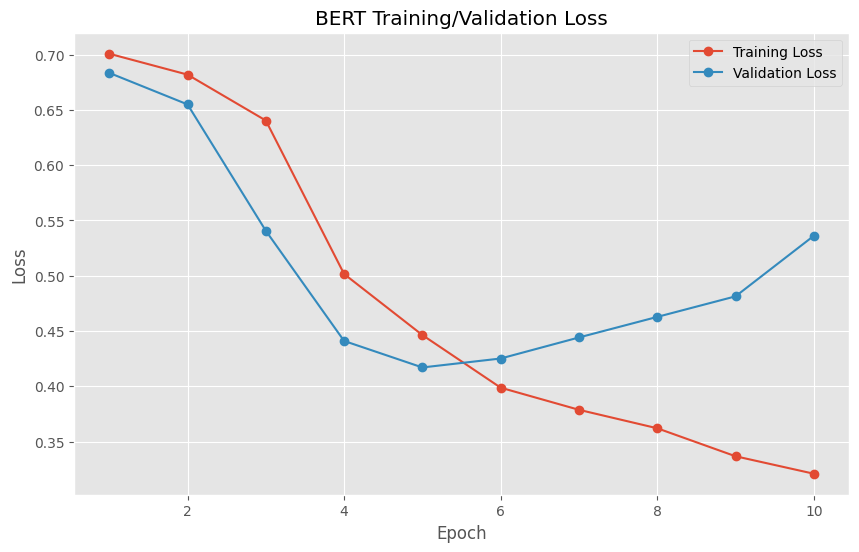

In [2]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))
training_loss = [0.7008, 0.6819, 0.6404, 0.5016, 0.4464, 0.3988, 0.3788, 0.3621, 0.3368, 0.321]
validation_loss = [0.683473, 0.654959, 0.540696, 0.441066, 0.417094, 0.425187, 0.444225, 0.46281, 0.481396, 0.536135]

plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, marker='o', label='Training Loss')
plt.plot(epochs, validation_loss, marker='o', label='Validation Loss')
plt.title('BERT Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

As we can see, the validation loss bottoms out around the 5th epoch and then turns upwards while the model begins to overfit.

We can also look at the performances of BERT vs RNN:

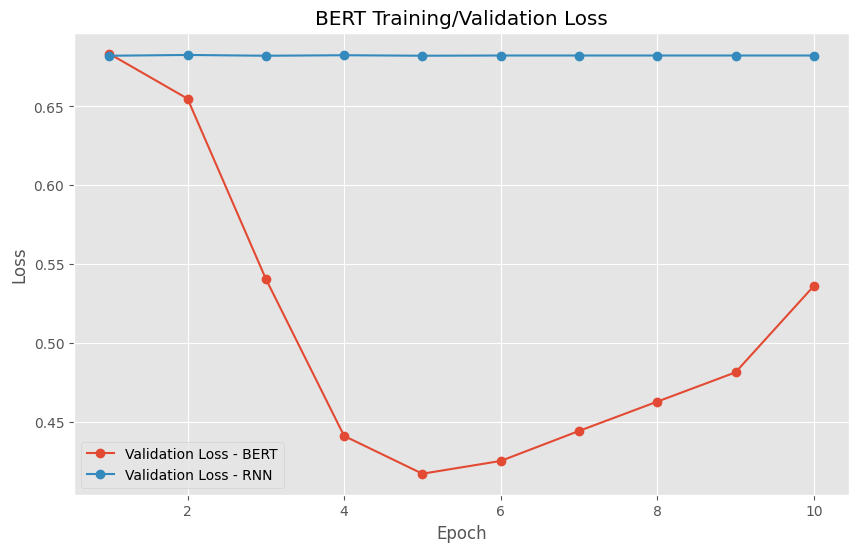

In [2]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))
validation_loss_bert = [0.683473, 0.654959, 0.540696, 0.441066, 0.417094, 0.425187, 0.444225, 0.46281, 0.481396, 0.536135]
validation_loss_rnn = [0.6821882724761963, 0.682688295841217, 0.6821914911270142, 0.6825106143951416, 0.6822011470794678, 0.6823351979255676, 0.6823351979255676, 0.6823351979255676, 0.6823351979255676, 0.6823351979255676]
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(epochs, validation_loss_bert, marker='o', label='Validation Loss - BERT')
plt.plot(epochs, validation_loss_rnn, marker='o', label='Validation Loss - RNN')
plt.title('BERT Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

We can see that the RNN's loss doesn't decrease almost at all, even with a higher learning rate than BERT. This is likely due to the shallow depth of the RNN which is a consequence of the computational costs associated with recurrence.

## 4.1 What helped?
In previous versions of my BERT model I used higher learning rates which led to early overfitting (validation loss began to increase after only 1-2 epochs); in the final version of the model this was remedied by using a very small learning rate of 1e-6 with a learning rate warmup.

Obviously, the transformer architecture also had a much greater performance and ability to learn than the RNN; this is because the attention mechanism allows for a larger model to be trained in the same amount of time.

# 5. Conclusion
To conclude, the biggest takeaway from this exercise was that the transformer architecture's attention mechanism is generally much more efficient in terms of training time/resources than RNNs.

Secondly, pre-trained models such as BERT can benefit from very low learning rates during fine-tuning; I started out with a relatively high LR but found that as low as 1e-6 (and potentially even lower) still converged within only a few epochs.

# References
Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.

Nistor, S. C., Moca, M., Moldovan, D., Oprean, D. B., & Nistor, R. L. (2021). Building a Twitter Sentiment Analysis System with Recurrent Neural Networks. Sensors (Basel, Switzerland), 21(7), 2266. https://doi.org/10.3390/s21072266